In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = r'E:\文件\BA项目集\天猫订单综合分析\tmall_order_report.csv'
df = pd.read_csv(path,engine = 'python',encoding = 'gbk')

In [3]:
df.head(1)

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
0,1,178.8,0.0,上海,2020/2/21 0:00,NaN,0.0


In [4]:
df.tail(1)

,订单编号,总金额,买家实际支付金额,收货地址,订单创建时间,订单付款时间,退款金额
28009,28010,37.0,37.0,广东省,2020/2/27 0:00,2020/2/27 0:00,0.0


In [5]:
df.columns

Index(['订单编号', '总金额', '买家实际支付金额', '收货地址', '订单创建时间', '订单付款时间', '退款金额'], dtype='object')

In [6]:
#将字段名称中空格去掉，规范字段名称
df = df.rename( columns = {'收货地址':'收货地址','订单付款时间':'订单付款时间'})
df.columns

Index(['订单编号', '总金额', '买家实际支付金额', '收货地址', '订单创建时间', '订单付款时间', '退款金额'], dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28010 entries, 0 to 28009
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   订单编号      28010 non-null  int64  
 1   总金额       28010 non-null  float64
 2   买家实际支付金额  28010 non-null  float64
 3   收货地址      28010 non-null  object 
 4   订单创建时间    28010 non-null  object 
 5   订单付款时间    24087 non-null  object 
 6   退款金额      28010 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.5+ MB


In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.isnull().sum()

订单编号           0
总金额            0
买家实际支付金额       0
收货地址           0
订单创建时间         0
订单付款时间      3923
退款金额           0
dtype: int64

In [10]:
dict_convs = dict()

In [11]:
key = '总订单数'
dict_convs[key] = len(df)
len(df)

28010

In [12]:
key = '付款订单数'
#付款时间不为空的，表示付过款
df_payed = df[df['订单付款时间'].notnull()]

dict_convs[key] = len(df_payed)

len(df_payed)

24087

In [13]:
key ='到款订单数'
#买家实际支付金额：总金额-退款金额（在已付款的情况下）
#买家实际支付金额不为0的，说明订单商家收到过款
df_trans=df_payed[df_payed['买家实际支付金额'] != 0]
dict_convs[key] = len(df_trans)
len(df_trans)

18955

In [14]:
key = '全额到款订单数'
#在付款的订单中，退款金额为0的，说明没有退款，表示全额收款
df_trans_full = df_payed[df_payed['退款金额'] == 0]
dict_convs[key] = len(df_trans_full)
len(df_trans_full)

18441

In [15]:
#查看转化数据
dict_convs

{'总订单数': 28010, '付款订单数': 24087, '到款订单数': 18955, '全额到款订单数': 18441}

In [16]:
df_convs = pd.Series(dict_convs,name = '订单数').to_frame()
df_convs

,订单数
总订单数,28010
付款订单数,24087
到款订单数,18955
全额到款订单数,18441


In [17]:
#添加总体转化率，每个环节除以总订单数
name = '总体转化率'
total_convs = df_convs['订单数']/df_convs.loc['总订单数','订单数']*100
df_convs[name] = total_convs.apply(lambda x : round(x,0))
df_convs

,订单数,总体转化率
总订单数,28010,100.0
付款订单数,24087,86.0
到款订单数,18955,68.0
全额到款订单数,18441,66.0


In [18]:
# 必须在其他 pyecharts 导入之前运行
from pyecharts.globals import CurrentConfig, NotebookType
# 如果你在 classic Jupyter Notebook（浏览器打开 .ipynb）
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK

# 如果你在 JupyterLab、或者 VSCode 的 Notebook（VSCode 通常需要 JUPYTER_LAB）
# CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_LAB

In [19]:
from pyecharts.charts import Funnel
from pyecharts import options as opts

In [20]:
name = '总体转化率'
funnel = (
    Funnel()
    .add(
        series_name = name,
        data_pair = [list(z) for z in zip(df_convs.index, df_convs['总体转化率'])],
        label_opts = opts.LabelOpts(position = 'inside')
    )
    .set_series_opts(
        tooltip_opts = opts.TooltipOpts(formatter = '{a}<br/>{b} : {c}%')
    )
    .set_global_opts(
        title_opts = opts.TitleOpts(title = name)
    )
)
funnel.render_notebook()

In [21]:
#添加单一环节转化率，每个环节除以上一环节
name='单一环节转化率'
single_convs =df_convs['订单数'].shift()
df_convs[name]=single_convs.fillna(df_convs.loc['总订单数','订单数'])
# df_convs[name] =(df_convs['订单数']/df_convs[name]*100).apply(lambda x : rour.
df_convs[name] =round((df_convs['订单数']/df_convs[name]*100),0)
df_convs

,订单数,总体转化率,单一环节转化率
总订单数,28010,100.0,100.0
付款订单数,24087,86.0,86.0
到款订单数,18955,68.0,79.0
全额到款订单数,18441,66.0,97.0


In [22]:
name='单一环节转化率'
funnel = Funnel().add(
series_name = name,
data_pair = [list(z)for z in zip(df_convs.index,df_convs['总体转化率'])],
label_opts =opts.LabelOpts(position='inside')
)
funnel.set_series_opts(tooltip_opts = opts.TooltipOpts(formatter = '{a}<br/>{b} : {c}%'))
funnel.set_global_opts(title_opts = opts.TitleOpts(title = name),
                        )
funnel.render_notebook()

In [23]:
#按到款订单统计
df_trans['订单创建时间']=df_trans['订单创建时间'].astype('datetime64[ns]')
df_trans=df_trans.set_index('订单创建时间')
df_trans.head(1)

,订单编号,总金额,买家实际支付金额,收货地址,订单付款时间,退款金额
订单创建时间,,,,,,
2020-02-20 23:59:00,2,21.0,21.0,内蒙古自治区,2020/2/21 0:00,0.0


'订单编号'

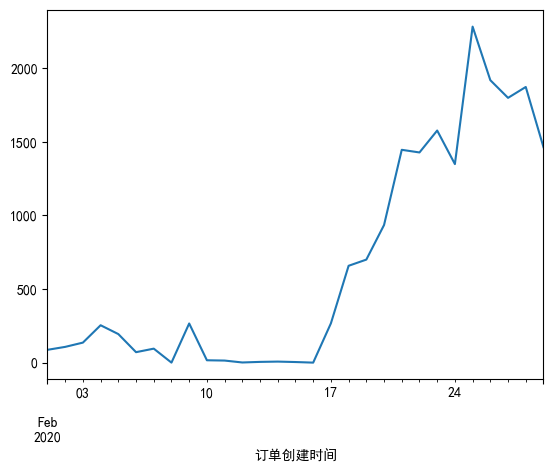

In [24]:
se_trans_month = df_trans.resample('D')['订单编号'].count()
se_trans_month.plot()
se_trans_month.name

In [25]:
from pyecharts.charts import Line

In [26]:
name ='订单数'
(
Line()
.add_xaxis(xaxis_data =list(se_trans_month.index.day.map(str)))
.add_yaxis(
series_name= name,
y_axis= se_trans_month,
)
.set_global_opts(
yaxis_opts = opts.AxisOpts(
splitline_opts = opts.SplitLineOpts(is_show= True)
)
)

)
funnel.render_notebook()

In [27]:
df_trans['买家实际支付金额'].mean()

np.float64(100.36861777895014)

<Axes: xlabel='收货地址'>

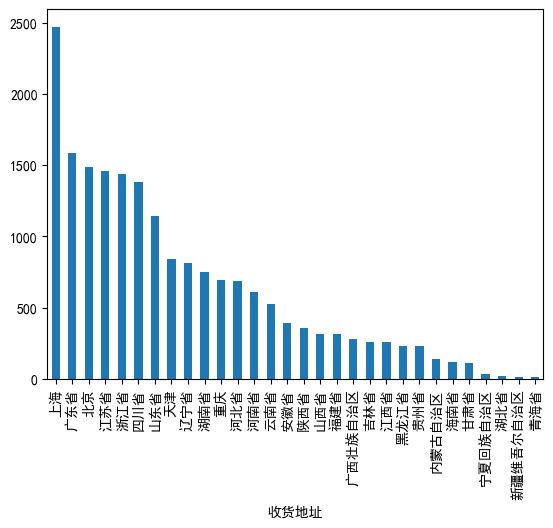

In [28]:
se_trans_map=df_trans.groupby('收货地址')['收货地址'].count().sort_values(ascending=False)
plt.figure(dpi=100)
se_trans_map.plot(kind ='bar')
# len(se_trans_map)

In [29]:
df.columns

Index(['订单编号', '总金额', '买家实际支付金额', '收货地址', '订单创建时间', '订单付款时间', '退款金额'], dtype='object')

In [30]:
#为了保持由于下面的地理分布图使用的省份名称一致，定义一个处理自治区的函数
def strip_region(iterable):
    result = []
    for i in iterable:
        if i.endswith('自治区'):
            if i == '内蒙古自治区':
                i = i[:3]
                result.append(i)
            else:
                result.append(i[:2])
        else:
            result.append(i)
    return result

In [31]:
#处理自治区，
se_trans_map.index = strip_region(se_trans_map.index)
#去掉末位“省”字
se_trans_map.index = se_trans_map.index.str.strip('省')

In [32]:
import pyecharts.options as opts
from pyecharts.charts import Map

In [33]:
# 展示地理分布图
name='订单数'
(
Map()
.add(
series_name = name,
data_pair= [list(i)for i in se_trans_map.items()])
.set_global_opts(visualmap_opts=opts.VisualMapOpts(
max_=max(se_trans_map)*0.6
)
                )
)
funnel.render_notebook()